#Imports

In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import torch
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.auto import tqdm
from datasets import load_dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    default_data_collator,
    get_scheduler
)
from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator

import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

import warnings

In [ ]:
# Supress User Warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# Dataset exploration

In [ ]:
# Load and examine one of the datasets
ds = load_dataset("mlqa", "mlqa.en.en", trust_remote_code=True)
ds

README.md:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

mlqa.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/11590 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1148 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['context', 'question', 'answers', 'id'],
        num_rows: 11590
    })
    validation: Dataset({
        features: ['context', 'question', 'answers', 'id'],
        num_rows: 1148
    })
})

In [ ]:
# Create a new train-val-test split

# Combine the original test and validation splits and shuffle
combined_split = concatenate_datasets([ds["validation"], ds["test"]]).shuffle(seed=42)

# Split into new training, validation, and test sets (80% train, 10% validation, 10% test)
train_val_split = combined_split.train_test_split(test_size=0.2)  # 20% for validation + test
validation_test_split = train_val_split["test"].train_test_split(test_size=0.5)  # 50% of the 20% -> 10% total for each

# Create the final dataset dictionary
dataset = DatasetDict({
    "train": train_val_split["train"],
    "validation": validation_test_split["train"],
    "test": validation_test_split["test"]
})

# Confirm the final split
dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answers', 'id'],
        num_rows: 10190
    })
    validation: Dataset({
        features: ['context', 'question', 'answers', 'id'],
        num_rows: 1274
    })
    test: Dataset({
        features: ['context', 'question', 'answers', 'id'],
        num_rows: 1274
    })
})

In [ ]:
# Examine a dataset example
print("Context: ", dataset["train"][0]["context"])
print("Question: ", dataset["train"][0]["question"])
print("Answer: ", dataset["train"][0]["answers"])

Context:  Nangarhār (Pashto: ننګرهار‎; Persian: ننگرهار‎), also called Nangrahar or Ningrahar, is one of the 34 provinces of Afghanistan, located in the eastern part of the country. It is divided into twenty-two districts and has a population of about 1,436,000. The city of Jalalabad is the capital of Nangarhar province.
Question:  Into how many districts is Nangrahar divided?
Answer:  {'answer_start': [191], 'text': ['twenty-two']}


In [ ]:
# Check if no answer or more than one answer per context-question pair is possible
print(dataset["train"].filter(lambda x: len(x["answers"]["text"]) != 1))
print(dataset["validation"].filter(lambda x: len(x["answers"]["text"]) != 1))
print(dataset["test"].filter(lambda x: len(x["answers"]["text"]) != 1))

Filter:   0%|          | 0/10190 [00:00<?, ? examples/s]

Dataset({
    features: ['context', 'question', 'answers', 'id'],
    num_rows: 0
})


Filter:   0%|          | 0/1274 [00:00<?, ? examples/s]

Dataset({
    features: ['context', 'question', 'answers', 'id'],
    num_rows: 0
})


Filter:   0%|          | 0/1274 [00:00<?, ? examples/s]

Dataset({
    features: ['context', 'question', 'answers', 'id'],
    num_rows: 0
})


In [ ]:
# Load the model and suitable tokenizer
model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (961 > 512). Running this sequence through the model will result in indexing errors


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


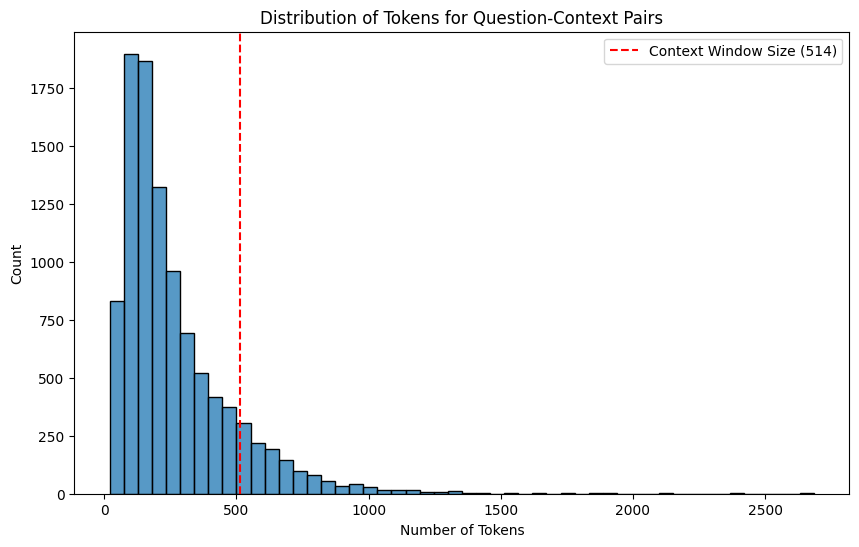

In [ ]:
# Compare the number of tokens in context-questions pairs with the context window size

# Get the length of tokens for each question-context pair
token_lengths = [len(tokenizer(q["question"], q["context"])["input_ids"]) for q in dataset['train']]

# Get the context window size
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
context_window_size = model.config.max_position_embeddings

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=50, stat="count")
plt.axvline(context_window_size, color='red', linestyle='--', label=f'Context Window Size ({context_window_size})')

# Add labels and legend
plt.title('Distribution of Tokens for Question-Context Pairs')
plt.xlabel('Number of Tokens')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
context = dataset["train"][0]["context"]
question = dataset["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'<s> Into how many districts is Nangrahar divided?</s></s> Nangarhār (Pashto: ننګرهار ; Persian: ننگرهار ), also called Nangrahar or Ningrahar, is one of the 34 provinces of Afghanistan, located in the eastern part of the country. It is divided into twenty-two districts and has a population of about 1,436,000. The city of Jalalabad is the capital of Nangarhar province.</s>'

# Preprocessing

### Data loading and splitting

In [ ]:
def load_and_split_dataset(language="english", seed=42):
    """
    Load dataset and create a train-val-test split

    Args:
        language: Language of the dataset (default: "english")
        seed: Random seed for shuffling

    Returns:
        Tuple of train, validation, and test datasets,
        and a DatasetDict with train, validation, and test splits
    """

    # Map language to dataset configuration
    lang_config = {
        "english": "mlqa.en.en",
        "chinese": "mlqa.zh.zh",
        "arabic": "mlqa.ar.ar",
        "german": "mlqa.de.de",
        "spanish": "mlqa.es.es",
        "hindi": "mlqa.hi.hi",
        "vietnamese": "mlqa.vi.vi"
    }

    config = lang_config[language]
    print(f"Loading dataset: MLQA with configuration '{config}'")

    # Load the dataset
    ds = load_dataset("mlqa", config, trust_remote_code=True)

    # Combine the original test and validation splits and shuffle
    combined_split = concatenate_datasets([ds["validation"], ds["test"]]).shuffle(seed=seed)

    # Split into new training, validation, and test sets (80% train, 10% validation, 10% test)
    train_val_split = combined_split.train_test_split(test_size=0.2)  # 20% for validation + test
    validation_test_split = train_val_split["test"].train_test_split(test_size=0.5)  # 10% each

    train = train_val_split["train"]
    validation = validation_test_split["train"]
    test = validation_test_split["test"]

    # Create the final dataset
    dataset = DatasetDict({
            "train": train,
            "validation": validation,
            "test": test
          })

    return train, validation, test, dataset

### Model and tokenizer initialization

In [ ]:
def initialize_tokenizer_and_model(model_checkpoint="xlm-roberta-base", load_pretrained=False, model_path=None):
    """
    Initialize tokenizer and model

    Args:
        model_checkpoint: Checkpoint to load from HuggingFace
        load_pretrained: Whether to load a fine-tuned model from disk
        model_path: Path to the fine-tuned model

    Returns:
        tokenizer, model
    """

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

    if load_pretrained and model_path and os.path.exists(model_path):
        print(f"Loading fine-tuned model from {model_path}")
        model = AutoModelForQuestionAnswering.from_pretrained(model_path)
    else:
        print(f"Loading model from checkpoint: {model_checkpoint}")
        model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

    return tokenizer, model

### Preprocessing and tokenization

In [ ]:
def create_preprocess_training_function(tokenizer, max_length=384, stride=128):
    """
    Create a preprocessing function for training data

    Args:
        tokenizer: Tokenizer to use
        max_length: Maximum sequence length
        stride: Stride for sliding window

    Returns:
        Preprocessing function for training examples
    """

    def preprocess_training_examples(examples):
        questions = [q.strip() for q in examples["question"]]  # Remove spaces
        inputs = tokenizer(
            questions,
            examples["context"],
            max_length=max_length,
            truncation="only_second",
            stride=stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )

        offset_mapping = inputs.pop("offset_mapping")
        sample_map = inputs.pop("overflow_to_sample_mapping")
        answers = examples["answers"]
        start_positions = []
        end_positions = []

        for i, offset in enumerate(offset_mapping):
            sample_idx = sample_map[i]
            answer = answers[sample_idx]
            start_char = answer["answer_start"][0]
            end_char = answer["answer_start"][0] + len(answer["text"][0])
            sequence_ids = inputs.sequence_ids(i)

            # Find the start and end of the context
            idx = 0
            while sequence_ids[idx] != 1:
                idx += 1
            context_start = idx
            while sequence_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            # If the answer is not fully inside the context, label is (0, 0)
            if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
                start_positions.append(0)
                end_positions.append(0)
            else:
                # Otherwise it's the start and end token positions
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)

        inputs["start_positions"] = start_positions
        inputs["end_positions"] = end_positions
        return inputs

    return preprocess_training_examples

In [ ]:
def create_preprocess_eval_function(tokenizer, max_length=384, stride=128):
    """
    Create a preprocessing function for validation and test data

    Args:
        tokenizer: Tokenizer to use
        max_length: Maximum sequence length
        stride: Stride for sliding window

    Returns:
        Preprocessing function for validation/test examples
    """

    def preprocess_validation_test_examples(examples):
        questions = [q.strip() for q in examples["question"]]
        inputs = tokenizer(
            questions,
            examples["context"],
            max_length=max_length,
            truncation="only_second",
            stride=stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )

        sample_map = inputs.pop("overflow_to_sample_mapping")
        example_ids = []

        for i in range(len(inputs["input_ids"])):
            sample_idx = sample_map[i]
            example_ids.append(examples["id"][sample_idx])

            sequence_ids = inputs.sequence_ids(i)
            offset = inputs["offset_mapping"][i]
            inputs["offset_mapping"][i] = [
                o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
            ]

        inputs["example_id"] = example_ids
        return inputs

    return preprocess_validation_test_examples

In [ ]:
def preprocess_datasets(dataset, tokenizer, max_length=384, stride=128):
    """
    Preprocess and tokenize all dataset splits

    Args:
        dataset: Dataset with train, validation, and test splits
        tokenizer: Tokenizer to use
        max_length: Maximum sequence length
        stride: Stride for sliding window

    Returns:
        Dictionary with preprocessed datasets
    """

    preprocess_train_fn = create_preprocess_training_function(tokenizer, max_length, stride)
    preprocess_eval_fn = create_preprocess_eval_function(tokenizer, max_length, stride)

    processed_datasets = {}

    # Preprocess training set if available
    if "train" in dataset:
        processed_datasets["train"] = dataset["train"].map(
            preprocess_train_fn,
            batched=True,
            remove_columns=dataset["train"].column_names,
        )

    # Preprocess validation set if available
    if "validation" in dataset:
        processed_datasets["validation"] = dataset["validation"].map(
            preprocess_eval_fn,
            batched=True,
            remove_columns=dataset["validation"].column_names,
        )

    # Preprocess test set if available
    if "test" in dataset:
        processed_datasets["test"] = dataset["test"].map(
            preprocess_eval_fn,
            batched=True,
            remove_columns=dataset["test"].column_names,
        )

    return processed_datasets

### DataLoader preparation

In [ ]:
def prepare_dataloaders(processed_datasets, batch_size=8):
    """
    Prepare PyTorch dataloaders for all splits

    Args:
        processed_datasets: Dictionary with preprocessed datasets
        batch_size: Batch size for dataloaders

    Returns:
        Dictionary with dataloaders
    """

    dataloaders = {}

    # Create train dataloader if available
    if "train" in processed_datasets:
        train_dataset = processed_datasets["train"]
        train_dataset.set_format("torch")

        dataloaders["train"] = DataLoader(
            train_dataset,
            shuffle=True,
            collate_fn=default_data_collator,
            batch_size=batch_size,
        )

    # Create validation dataloader if available
    if "validation" in processed_datasets:
        validation_set = processed_datasets["validation"].remove_columns(["example_id", "offset_mapping"])
        validation_set.set_format("torch")

        dataloaders["validation"] = DataLoader(
            validation_set,
            collate_fn=default_data_collator,
            batch_size=batch_size
        )

    # Create test dataloader if available
    if "test" in processed_datasets:
        test_set = processed_datasets["test"].remove_columns(["example_id", "offset_mapping"])
        test_set.set_format("torch")

        dataloaders["test"] = DataLoader(
            test_set,
            collate_fn=default_data_collator,
            batch_size=batch_size
        )

    return dataloaders

### Evaluation metrics

In [ ]:
def compute_exact_match(predictions, references):
    """
    Compute exact match score

    Args:
        predictions: List of prediction dictionaries
        references: List of reference dictionaries

    Returns:
        Exact match score (percentage)
    """

    exact_match = 0
    for pred, ref in zip(predictions, references):
        if pred['prediction_text'].lower() == ref['answers']['text'][0].lower():
            exact_match += 1

    em_score = exact_match / len(predictions) * 100  # Multiply by 100 to get percentage
    return round(em_score, 2)

In [ ]:
def compute_f1(predictions, references):
    """
    Compute F1 score

    Args:
        predictions: List of prediction dictionaries
        references: List of reference dictionaries

    Returns:
        F1 score (percentage)
    """

    f1 = 0
    for pred, ref in zip(predictions, references):
        pred_tokens = set(pred['prediction_text'].split())
        ref_tokens = set(ref['answers']['text'][0].split())

        # Precision: how many tokens in prediction overlap with reference
        precision = len(pred_tokens & ref_tokens) / len(pred_tokens) if pred_tokens else 0

        # Recall: how many tokens in reference overlap with prediction
        recall = len(pred_tokens & ref_tokens) / len(ref_tokens) if ref_tokens else 0

        # F1 score
        f1 += 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    f1_score = f1 / len(predictions) * 100  # Average F1 score and multiply by 100
    return round(f1_score, 2)

In [ ]:
def compute_em_f1(predictions, references):
    """
    Compute both exact match and F1 scores

    Args:
        predictions: List of prediction dictionaries
        references: List of reference dictionaries

    Returns:
        Dictionary with exact match and F1 scores
    """

    em_score = compute_exact_match(predictions, references)
    f1_score = compute_f1(predictions, references)
    return {"exact_match": em_score, "f1": f1_score}

In [ ]:
def compute_metrics(start_logits, end_logits, features, examples, n_best=20, max_answer_length=30):
    """
    Compute evaluation metrics from model outputs

    Args:
        start_logits: Start position logits from model
        end_logits: End position logits from model
        features: Processed features
        examples: Original examples
        n_best: Number of best answers to consider
        max_answer_length: Maximum answer length

    Returns:
        Dictionary with evaluation metrics
    """

    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return compute_em_f1(predicted_answers, theoretical_answers)

# Training

In [ ]:
def train_model(model, train_dataloader, eval_dataloader, validation_dataset, original_validation_dataset,
                num_epochs=3, learning_rate=2e-5, output_dir="./output_model"):
    """
    Train the model and evaluate on validation set

    Args:
        model: Model to train
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for validation data
        validation_dataset: Processed validation dataset
        original_validation_dataset: Original validation dataset
        num_epochs: Number of training epochs
        learning_rate: Learning rate
        output_dir: Directory to save model

    Returns:
        Trained model
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Initialize accelerator
    accelerator = Accelerator()
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )

    # Calculate training steps
    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_epochs * num_update_steps_per_epoch

    # Initialize learning rate scheduler
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Initialize progress bar
    progress_bar = tqdm(range(num_training_steps))

    # Training loop
    best_f1 = 0
    for epoch in range(num_epochs):
        # Training
        model.train()
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        # Evaluation
        model.eval()

        # Initialize lists to store predictions
        start_logits = []
        end_logits = []

        # Make predictions on validation dataset
        accelerator.print(f"\tEvaluation for Epoch {epoch+1}")
        for batch in tqdm(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)

            # Gather predictions
            start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
            end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

        # Concatenate predictions
        start_logits = np.concatenate(start_logits)
        end_logits = np.concatenate(end_logits)
        start_logits = start_logits[: len(validation_dataset)]
        end_logits = end_logits[: len(validation_dataset)]

        # Compute metrics
        metrics = compute_metrics(
            start_logits, end_logits, validation_dataset, original_validation_dataset
        )
        print(f"\n\tEpoch {epoch+1}:", metrics)

        # Save model (best model based on F1 score and last model)
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)

        # Save the model at the end of each epoch
        epoch_dir = os.path.join(output_dir, f"epoch_{epoch+1}")
        os.makedirs(epoch_dir, exist_ok=True)
        unwrapped_model.save_pretrained(epoch_dir, save_function=accelerator.save)

        # Save the best model based on F1 score
        if metrics["f1"] > best_f1:
            best_f1 = metrics["f1"]
            best_model_dir = os.path.join(output_dir, "best_model")
            os.makedirs(best_model_dir, exist_ok=True)
            unwrapped_model.save_pretrained(best_model_dir, save_function=accelerator.save)
            print(f"New best model saved with F1: {best_f1}")

    # Save the final model
    final_model_dir = os.path.join(output_dir, "final_model")
    os.makedirs(final_model_dir, exist_ok=True)
    unwrapped_model.save_pretrained(final_model_dir, save_function=accelerator.save)
    print(f"\nFinal model saved to {final_model_dir}")

    return model

In [ ]:
def evaluate_model(model, test_dataloader, test_dataset, original_test_dataset, language="en"):
    """
    Evaluate model on test set

    Args:
        model: Trained model
        test_dataloader: DataLoader for test data
        test_dataset: Processed test dataset
        original_test_dataset: Original test dataset
        language: Language of the test set

    Returns:
        Dictionary with evaluation metrics
    """

    # Initialize accelerator
    accelerator = Accelerator()
    model, test_dataloader = accelerator.prepare(model, test_dataloader)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []

    # Make predictions on test dataset
    print(f"\nEvaluating model on {language.capitalize()} test set...")
    for batch in tqdm(test_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        # Gather predictions
        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    # Concatenate predictions
    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[:len(test_dataset)]
    end_logits = end_logits[:len(test_dataset)]

    # Compute metrics
    metrics = compute_metrics(
        start_logits, end_logits, test_dataset, original_test_dataset
    )

    print(f"\nEvaluation metrics on {language.capitalize()} test set:", metrics)
    return metrics

In [ ]:
def run_training_pipeline(train_language="english"):
    """
    Run the complete pipeline for training on any language data.

    Args:
        train_language (str): Language for training (e.g., 'english', 'chinese')
    """

    # Configuration
    model_checkpoint = "xlm-roberta-base"
    max_length = 384
    stride = 128
    batch_size = 8
    learning_rate = 2e-5
    num_epochs = 3
    output_dir = f"./xlm_r_qa_model_{train_language}"

    # Load and split datasets
    train_dataset, val_dataset, test_dataset, _ = load_and_split_dataset(
        language=train_language,
    )

    # Initialize tokenizer and model
    print("\nInitializing tokenizer and model...")
    tokenizer, model = initialize_tokenizer_and_model(model_checkpoint)


    # Preprocess datasets
    print("\nPreprocessing datasets...")
    processed_train_dataset = preprocess_datasets(
        {"train": train_dataset, "validation": val_dataset, "test": test_dataset},
        tokenizer,
        max_length,
        stride
    )

    # Prepare dataloaders
    print("\nPreparing dataloaders...")
    train_dataloaders = prepare_dataloaders(processed_train_dataset, batch_size)

    # Train model
    print(f"\nTraining model on {train_language.capitalize()} data...")
    model = train_model(
        model,
        train_dataloaders["train"],
        train_dataloaders["validation"],
        processed_train_dataset["validation"],
        val_dataset,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_dir=output_dir
    )

    # Evaluate model
    metrics = evaluate_model(
        model,
        train_dataloaders["test"],
        processed_train_dataset["test"],
        test_dataset,
        language=train_language
    )

    return model, tokenizer, output_dir, metrics


# Multilingual Evaluation

In [ ]:
def evaluate_on_multiple_languages(model_path, tokenizer):
    """
    Evaluate the trained model on multiple language test sets

    Args:
        model_path: Path to the trained model
        tokenizer: Tokenizer to use

    Returns:
        Dictionary with evaluation metrics for each language
    """

    # Configuration
    max_length = 384
    stride = 128
    batch_size = 8

    # Define language configurations
    languages = {
        "English": "mlqa.en.en",
        "Arabic": "mlqa.ar.ar",
        "German": "mlqa.de.de",
        "Spanish": "mlqa.es.es",
        "Hindi": "mlqa.hi.hi",
        "Vietnamese": "mlqa.vi.vi",
        "Chinese": "mlqa.zh.zh"
    }

    # Load the trained model
    print(f"\nLoading trained model from {model_path}...")
    _, model = initialize_tokenizer_and_model(load_pretrained=True, model_path=model_path)

    # Dictionary to store results for each language
    all_metrics = {}

    # Evaluate on each language
    for lang_name, lang_config in languages.items():
        print(f"\n{'='*50}")
        print(f"Evaluating on {lang_name}...")
        print(f"{'='*50}")

        # Load dataset for the language
        lang_dataset = load_dataset("mlqa", lang_config, trust_remote_code=True)

        # Create dataset dictionary with only the test split
        dataset = DatasetDict({"test": lang_dataset["test"]})

        # Preprocess test set
        processed_datasets = preprocess_datasets(dataset, tokenizer, max_length, stride)

        # Prepare test dataloader
        dataloaders = prepare_dataloaders(processed_datasets, batch_size)

        # Evaluate model on test set
        metrics = evaluate_model(
            model,
            dataloaders["test"],
            processed_datasets["test"],
            dataset["test"],
            language=lang_name
        )

        # Store the metrics
        all_metrics[lang_name] = metrics

    return all_metrics

In [ ]:
def visualize_cross_lingual_results(all_metrics):
    """
    Visualize the cross-lingual evaluation results

    Args:
        all_metrics: Dictionary with metrics for each language

    Returns:
        None (displays visualization)
    """

    languages = [lang.capitalize() for lang in all_metrics.keys()]
    exact_match_scores = [metrics["exact_match"] for metrics in all_metrics.values()]
    f1_scores = [metrics["f1"] for metrics in all_metrics.values()]

    # Set up the figure
    plt.figure(figsize=(12, 8))

    # Set the width of the bars
    bar_width = 0.35
    index = np.arange(len(languages))

    # Plot the bars
    plt.bar(index, exact_match_scores, bar_width, label='Exact Match', color='royalblue')
    plt.bar(index + bar_width, f1_scores, bar_width, label='F1 Score', color='lightcoral')

    # Add labels and title
    plt.xlabel(None)
    plt.ylabel('Scores (%)')
    plt.title('Cross-lingual Transfer Performance of XLM-RoBERTa QA Model')
    plt.xticks(index + bar_width / 2, languages)
    plt.ylim(0, 100)  # Set y-axis from 0 to 100 for percentage scale

    # Add a grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend
    plt.legend()

    # Add value labels on top of each bar
    for i, v in enumerate(exact_match_scores):
        plt.text(i - 0.05, v + 1, f"{v:.1f}", fontsize=10)
    for i, v in enumerate(f1_scores):
        plt.text(i + bar_width - 0.05, v + 1, f"{v:.1f}", fontsize=10)

    # Save the figure
    plt.savefig('cross_lingual_performance.png', dpi=300, bbox_inches='tight')

    # Show the plot
    print("\n")
    plt.tight_layout()
    plt.show()

    # Create a table with the results
    print("\nCross-lingual Transfer Results:")
    print("-" * 60)
    print(f"{'Language':<12} | {'Exact Match (%)':<15} | {'F1 Score (%)':<15}")
    print("-" * 60)

    for lang, metrics in all_metrics.items():
        print(f"{lang.capitalize():<12} | {metrics['exact_match']:<15.2f} | {metrics['f1']:<15.2f}")

    print("-" * 60)

    # Calculate average performance
    avg_em = sum(exact_match_scores) / len(exact_match_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print(f"{'Average':<12} | {avg_em:<15.2f} | {avg_f1:<15.2f}")
    print("-" * 60)

In [ ]:
def analyze_performance_gaps(all_metrics, reference_language="english"):
    """
    Analyze performance gaps between languages and a chosen reference language.

    Args:
        all_metrics (dict): Dictionary with metrics for each language.
        reference_language (str): The language to use as the performance reference.

    Returns:
        None (prints analysis).
    """

    # Check if reference language exists in metrics
    if reference_language not in all_metrics:
        print(f"Error: Reference language '{reference_language.capitalize()}' not found in metrics.")
        return

    ref_metrics = all_metrics[reference_language]
    ref_em = ref_metrics["exact_match"]
    ref_f1 = ref_metrics["f1"]

    print(f"\nPerformance Gap Analysis (relative to {reference_language.capitalize()}):")
    print("-" * 75)
    print(f"{'Language':<12} | {'EM Gap (%)':<12} | {'F1 Gap (%)':<12} | {'Relative EM (%)':<15} | {'Relative F1 (%)':<15}")
    print("-" * 75)

    for lang, metrics in all_metrics.items():
        if lang == reference_language:
            continue

        em_gap = ref_em - metrics["exact_match"]
        f1_gap = ref_f1 - metrics["f1"]

        # Relative performance (as percentage of reference performance)
        relative_em = (metrics["exact_match"] / ref_em) * 100 if ref_em > 0 else 0
        relative_f1 = (metrics["f1"] / ref_f1) * 100 if ref_f1 > 0 else 0

        print(f"{lang.capitalize():<12} | {em_gap:+<12.2f} | {f1_gap:+<12.2f} | {relative_em:<15.2f} | {relative_f1:<15.2f}")

    print("-" * 75)

    # Language clustering analysis
    print("\nLanguage Similarity Analysis:")
    print("-" * 50)

    # Extract F1 scores
    languages = list(all_metrics.keys())
    f1_scores = [metrics["f1"] for metrics in all_metrics.values()]

    # Create a distance matrix based on F1 score differences
    f1_array = np.array(f1_scores).reshape(-1, 1)
    dist_matrix = pdist(f1_array, metric='euclidean')

    # Perform hierarchical clustering
    Z = linkage(dist_matrix, method='ward')
    clusters = fcluster(Z, t=5, criterion='distance')

    # Group languages by cluster
    cluster_dict = {}
    for i, cluster_id in enumerate(clusters):
        cluster_dict.setdefault(cluster_id, []).append((languages[i], f1_scores[i]))

    # Print language clusters
    for cluster_id, language_group in cluster_dict.items():
        lang_names = [lang.capitalize() for lang, _ in language_group]
        avg_f1 = np.mean([f1 for _, f1 in language_group])
        print(f"Cluster {cluster_id}: {lang_names} (Avg F1: {avg_f1:.2f}%)")

    print("-" * 50)

In [ ]:
def main_multilingual_evaluation(train_language="english"):
    """
    Main function to run multilingual evaluation

    Args:
        train_language (str): Language code to train the model on.
    """

    # Define model checkpoint and paths
    model_checkpoint = "xlm-roberta-base"
    output_dir = f"./xlm_r_qa_model_{train_language}"
    best_model_path = os.path.join(output_dir, "best_model")

    # Initialize tokenizer
    tokenizer, _ = initialize_tokenizer_and_model(model_checkpoint)

    # Train model on the specified language
    print(f"\nTraining model on {train_language.capitalize()} data first...")
    _, _, _, metric = run_training_pipeline(train_language=train_language)

    # Load the trained model
    _, model = initialize_tokenizer_and_model(load_pretrained=True, model_path=best_model_path)

    reference_languages = ["english", "chinese", "arabic", "german", "spanish", "hindi", "vietnamese"]

    # Store metrics
    all_metrics = {}

    all_metrics[train_language] = metric

    # Test on all languages
    for lang in reference_languages:
      if lang != train_language:
        print(f"\n\n== Evaluation on {lang.capitalize()}", "="*50, "\n")

        # Load and preprocess dataset for this language
        _, _, _, dataset = load_and_split_dataset(language=lang)
        max_length, stride, batch_size = 384, 128, 8
        processed_datasets = preprocess_datasets(
            DatasetDict({"test": dataset["test"]}),
            tokenizer,
            max_length,
            stride
        )

        # Prepare dataloader
        dataloaders = prepare_dataloaders(processed_datasets, batch_size)

        # Evaluate model
        metrics = evaluate_model(
            model,
            dataloaders["test"],
            processed_datasets["test"],
            dataset["test"],
            language=lang
        )

        all_metrics[lang] = metrics

    # Visualize and analyze performance gaps
    visualize_cross_lingual_results(all_metrics)
    analyze_performance_gaps(all_metrics, reference_language=train_language)

    # Save results to a file
    results_file = f'multilingual_evaluation_results_{train_language}.txt'
    with open(results_file, 'w') as f:
        f.write(f"Cross-lingual Transfer Results (Trained on {train_language.capitalize()}):\n")
        f.write("-" * 60 + "\n")
        f.write(f"{'Language':<12} | {'Exact Match (%)':<15} | {'F1 Score (%)':<15}\n")
        f.write("-" * 60 + "\n")

        for lang, metrics in all_metrics.items():
            f.write(f"{lang:<12} | {metrics['exact_match']:<15.2f} | {metrics['f1']:<15.2f}\n")

        f.write("-" * 60 + "\n")

        # Calculate average performance
        exact_match_scores = [metrics["exact_match"] for metrics in all_metrics.values()]
        f1_scores = [metrics["f1"] for metrics in all_metrics.values()]
        avg_em = sum(exact_match_scores) / len(exact_match_scores)
        avg_f1 = sum(f1_scores) / len(f1_scores)

        f.write(f"{'Average':<12} | {avg_em:<15.2f} | {avg_f1:<15.2f}\n")

    print(f"\nResults saved to '{results_file}'")

# Results

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Loading model from checkpoint: xlm-roberta-base


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training model on English data first...
Loading dataset: MLQA with configuration 'mlqa.en.en'


README.md:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

mlqa.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/11590 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1148 [00:00<?, ? examples/s]


Initializing tokenizer and model...


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Preprocessing datasets...


Map:   0%|          | 0/10190 [00:00<?, ? examples/s]

Map:   0%|          | 0/1274 [00:00<?, ? examples/s]

Map:   0%|          | 0/1274 [00:00<?, ? examples/s]


Preparing dataloaders...

Training model on English data...


  0%|          | 0/5046 [00:00<?, ?it/s]

	Evaluation for Epoch 1


  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


	Epoch 1: {'exact_match': 51.96, 'f1': 68.87}
New best model saved with F1: 68.87
	Evaluation for Epoch 2


  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


	Epoch 2: {'exact_match': 56.04, 'f1': 72.2}
New best model saved with F1: 72.2
	Evaluation for Epoch 3


  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


	Epoch 3: {'exact_match': 56.36, 'f1': 72.52}
New best model saved with F1: 72.52

Final model saved to ./xlm_r_qa_model_english/final_model

Evaluating model on English test set...


  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


Evaluation metrics on English test set: {'exact_match': 57.3, 'f1': 75.24}
Loading fine-tuned model from ./xlm_r_qa_model_english/best_model


== Evaluation on Chinese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.zh.zh'


Generating test split:   0%|          | 0/5137 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/504 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]


Evaluating model on Chinese test set...


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]


Evaluation metrics on Chinese test set: {'exact_match': 38.41, 'f1': 39.14}


== Evaluation on Arabic ================================================== 

Loading dataset: MLQA with configuration 'mlqa.ar.ar'


Generating test split:   0%|          | 0/5335 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/586 [00:00<?, ? examples/s]


Evaluating model on Arabic test set...


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]


Evaluation metrics on Arabic test set: {'exact_match': 30.72, 'f1': 52.33}


== Evaluation on German ================================================== 

Loading dataset: MLQA with configuration 'mlqa.de.de'


Generating test split:   0%|          | 0/4517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/512 [00:00<?, ? examples/s]

Map:   0%|          | 0/503 [00:00<?, ? examples/s]


Evaluating model on German test set...


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


Evaluation metrics on German test set: {'exact_match': 37.97, 'f1': 54.58}


== Evaluation on Spanish ================================================== 

Loading dataset: MLQA with configuration 'mlqa.es.es'


Generating test split:   0%|          | 0/5253 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/576 [00:00<?, ? examples/s]


Evaluating model on Spanish test set...


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]


Evaluation metrics on Spanish test set: {'exact_match': 32.12, 'f1': 57.43}


== Evaluation on Hindi ================================================== 

Loading dataset: MLQA with configuration 'mlqa.hi.hi'


Generating test split:   0%|          | 0/4918 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/543 [00:00<?, ? examples/s]


Evaluating model on Hindi test set...


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]


Evaluation metrics on Hindi test set: {'exact_match': 40.7, 'f1': 57.59}


== Evaluation on Vietnamese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.vi.vi'


Generating test split:   0%|          | 0/5495 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/511 [00:00<?, ? examples/s]

Map:   0%|          | 0/601 [00:00<?, ? examples/s]


Evaluating model on Vietnamese test set...


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


Evaluation metrics on Vietnamese test set: {'exact_match': 43.59, 'f1': 64.93}




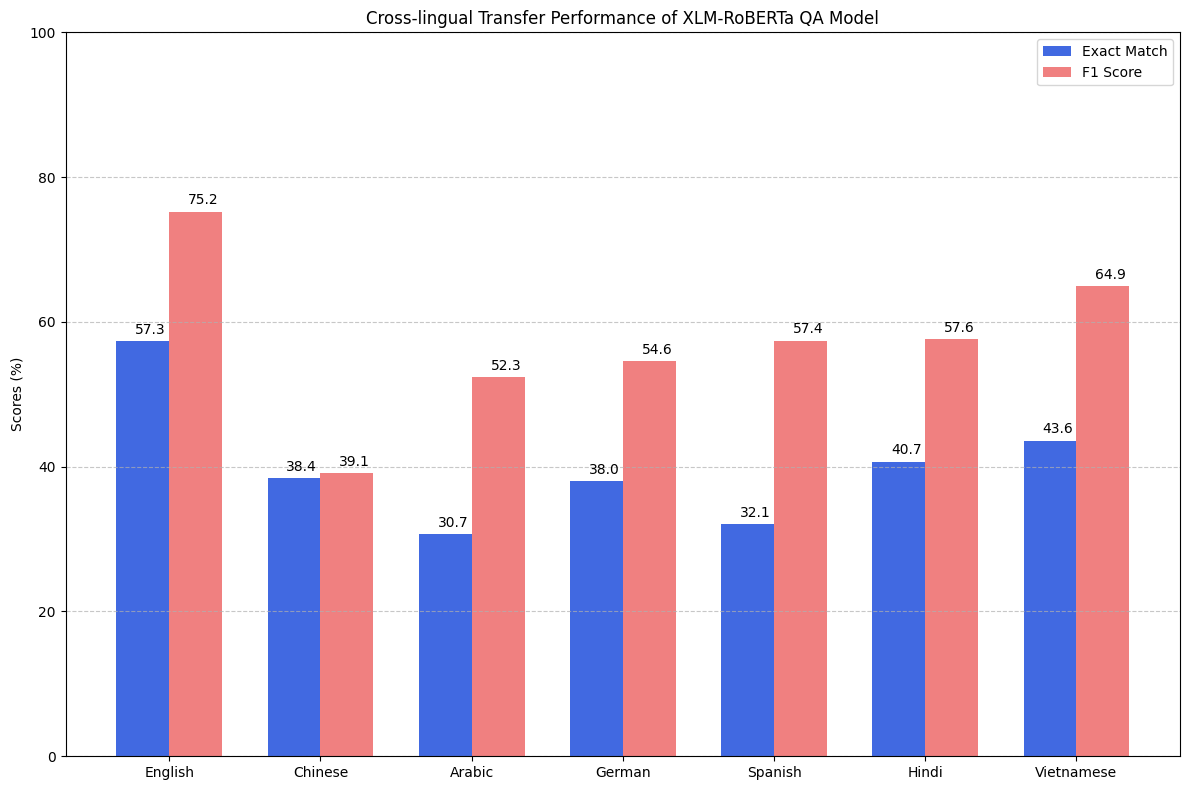


Cross-lingual Transfer Results:
------------------------------------------------------------
Language     | Exact Match (%) | F1 Score (%)   
------------------------------------------------------------
English      | 57.30           | 75.24          
Chinese      | 38.41           | 39.14          
Arabic       | 30.72           | 52.33          
German       | 37.97           | 54.58          
Spanish      | 32.12           | 57.43          
Hindi        | 40.70           | 57.59          
Vietnamese   | 43.59           | 64.93          
------------------------------------------------------------
Average      | 40.12           | 57.32          
------------------------------------------------------------

Performance Gap Analysis (relative to English):
---------------------------------------------------------------------------
Language     | EM Gap (%)   | F1 Gap (%)   | Relative EM (%) | Relative F1 (%)
---------------------------------------------------------------------------
Ch

In [ ]:
# Train on English
if __name__ == "__main__":
    # Run the full multilingual evaluation pipeline
    main_multilingual_evaluation(train_language="english")

Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Training model on Arabic data first...
Loading dataset: MLQA with configuration 'mlqa.ar.ar'

Initializing tokenizer and model...


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Preprocessing datasets...


Map:   0%|          | 0/4681 [00:00<?, ? examples/s]

Map:   0%|          | 0/585 [00:00<?, ? examples/s]

Map:   0%|          | 0/586 [00:00<?, ? examples/s]


Preparing dataloaders...

Training model on Arabic data...


  0%|          | 0/2241 [00:00<?, ?it/s]

	Evaluation for Epoch 1


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]


	Epoch 1: {'exact_match': 23.42, 'f1': 41.15}
New best model saved with F1: 41.15
	Evaluation for Epoch 2


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]


	Epoch 2: {'exact_match': 29.57, 'f1': 47.88}
New best model saved with F1: 47.88
	Evaluation for Epoch 3


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]


	Epoch 3: {'exact_match': 29.91, 'f1': 47.78}

Final model saved to ./xlm_r_qa_model_arabic/final_model

Evaluating model on Arabic test set...


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]


Evaluation metrics on Arabic test set: {'exact_match': 28.84, 'f1': 48.57}
Loading fine-tuned model from ./xlm_r_qa_model_arabic/best_model


== Evaluation on English ================================================== 

Loading dataset: MLQA with configuration 'mlqa.en.en'


Map:   0%|          | 0/1274 [00:00<?, ? examples/s]


Evaluating model on English test set...


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


Evaluation metrics on English test set: {'exact_match': 44.27, 'f1': 60.7}


== Evaluation on Chinese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.zh.zh'


Map:   0%|          | 0/565 [00:00<?, ? examples/s]


Evaluating model on Chinese test set...


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]


Evaluation metrics on Chinese test set: {'exact_match': 30.97, 'f1': 31.83}


== Evaluation on German ================================================== 

Loading dataset: MLQA with configuration 'mlqa.de.de'


Map:   0%|          | 0/503 [00:00<?, ? examples/s]


Evaluating model on German test set...


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


Evaluation metrics on German test set: {'exact_match': 29.22, 'f1': 46.36}


== Evaluation on Spanish ================================================== 

Loading dataset: MLQA with configuration 'mlqa.es.es'


Map:   0%|          | 0/576 [00:00<?, ? examples/s]


Evaluating model on Spanish test set...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]


Evaluation metrics on Spanish test set: {'exact_match': 25.17, 'f1': 46.62}


== Evaluation on Hindi ================================================== 

Loading dataset: MLQA with configuration 'mlqa.hi.hi'


Map:   0%|          | 0/543 [00:00<?, ? examples/s]


Evaluating model on Hindi test set...


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]


Evaluation metrics on Hindi test set: {'exact_match': 31.68, 'f1': 48.01}


== Evaluation on Vietnamese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.vi.vi'


Map:   0%|          | 0/601 [00:00<?, ? examples/s]


Evaluating model on Vietnamese test set...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


Evaluation metrics on Vietnamese test set: {'exact_match': 29.28, 'f1': 50.76}




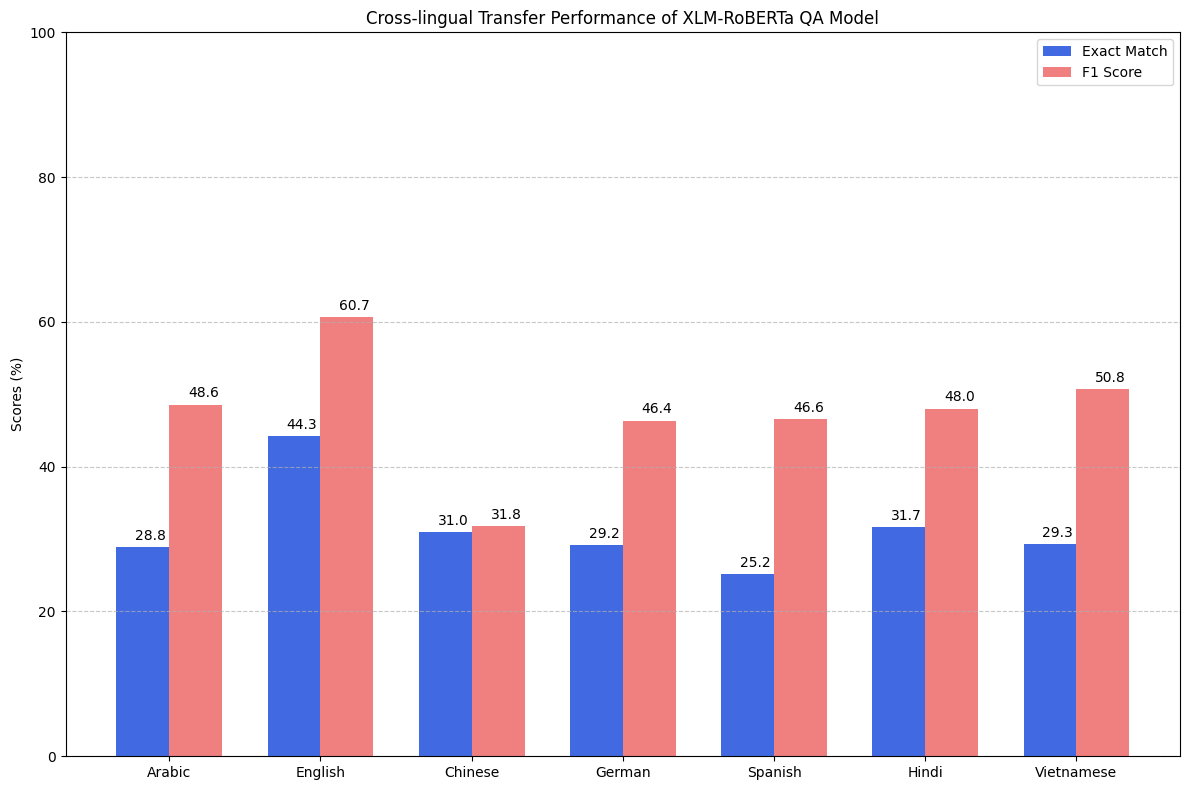


Cross-lingual Transfer Results:
------------------------------------------------------------
Language     | Exact Match (%) | F1 Score (%)   
------------------------------------------------------------
Arabic       | 28.84           | 48.57          
English      | 44.27           | 60.70          
Chinese      | 30.97           | 31.83          
German       | 29.22           | 46.36          
Spanish      | 25.17           | 46.62          
Hindi        | 31.68           | 48.01          
Vietnamese   | 29.28           | 50.76          
------------------------------------------------------------
Average      | 31.35           | 47.55          
------------------------------------------------------------

Performance Gap Analysis (relative to Arabic):
---------------------------------------------------------------------------
Language     | EM Gap (%)   | F1 Gap (%)   | Relative EM (%) | Relative F1 (%)
---------------------------------------------------------------------------
Eng

In [ ]:
# Train on Arabic
if __name__ == "__main__":
    main_multilingual_evaluation(train_language="arabic")

Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Training model on German data first...
Loading dataset: MLQA with configuration 'mlqa.de.de'

Initializing tokenizer and model...


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Preprocessing datasets...


Map:   0%|          | 0/4023 [00:00<?, ? examples/s]

Map:   0%|          | 0/503 [00:00<?, ? examples/s]

Map:   0%|          | 0/503 [00:00<?, ? examples/s]


Preparing dataloaders...

Training model on German data...


  0%|          | 0/1767 [00:00<?, ?it/s]

	Evaluation for Epoch 1


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


	Epoch 1: {'exact_match': 33.0, 'f1': 47.11}
New best model saved with F1: 47.11
	Evaluation for Epoch 2


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


	Epoch 2: {'exact_match': 37.77, 'f1': 52.71}
New best model saved with F1: 52.71
	Evaluation for Epoch 3


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


	Epoch 3: {'exact_match': 37.97, 'f1': 52.03}

Final model saved to ./xlm_r_qa_model_german/final_model

Evaluating model on German test set...


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


Evaluation metrics on German test set: {'exact_match': 33.4, 'f1': 48.68}
Loading fine-tuned model from ./xlm_r_qa_model_german/best_model


== Evaluation on English ================================================== 

Loading dataset: MLQA with configuration 'mlqa.en.en'


Map:   0%|          | 0/1274 [00:00<?, ? examples/s]


Evaluating model on English test set...


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


Evaluation metrics on English test set: {'exact_match': 29.75, 'f1': 52.46}


== Evaluation on Chinese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.zh.zh'


Map:   0%|          | 0/565 [00:00<?, ? examples/s]


Evaluating model on Chinese test set...


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]


Evaluation metrics on Chinese test set: {'exact_match': 23.01, 'f1': 23.92}


== Evaluation on Arabic ================================================== 

Loading dataset: MLQA with configuration 'mlqa.ar.ar'


Map:   0%|          | 0/586 [00:00<?, ? examples/s]


Evaluating model on Arabic test set...


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]


Evaluation metrics on Arabic test set: {'exact_match': 20.82, 'f1': 40.88}


== Evaluation on Spanish ================================================== 

Loading dataset: MLQA with configuration 'mlqa.es.es'


Map:   0%|          | 0/576 [00:00<?, ? examples/s]


Evaluating model on Spanish test set...


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]


Evaluation metrics on Spanish test set: {'exact_match': 27.08, 'f1': 47.69}


== Evaluation on Hindi ================================================== 

Loading dataset: MLQA with configuration 'mlqa.hi.hi'


Map:   0%|          | 0/543 [00:00<?, ? examples/s]


Evaluating model on Hindi test set...


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]


Evaluation metrics on Hindi test set: {'exact_match': 32.04, 'f1': 48.66}


== Evaluation on Vietnamese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.vi.vi'


Map:   0%|          | 0/601 [00:00<?, ? examples/s]


Evaluating model on Vietnamese test set...


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


Evaluation metrics on Vietnamese test set: {'exact_match': 25.12, 'f1': 46.78}




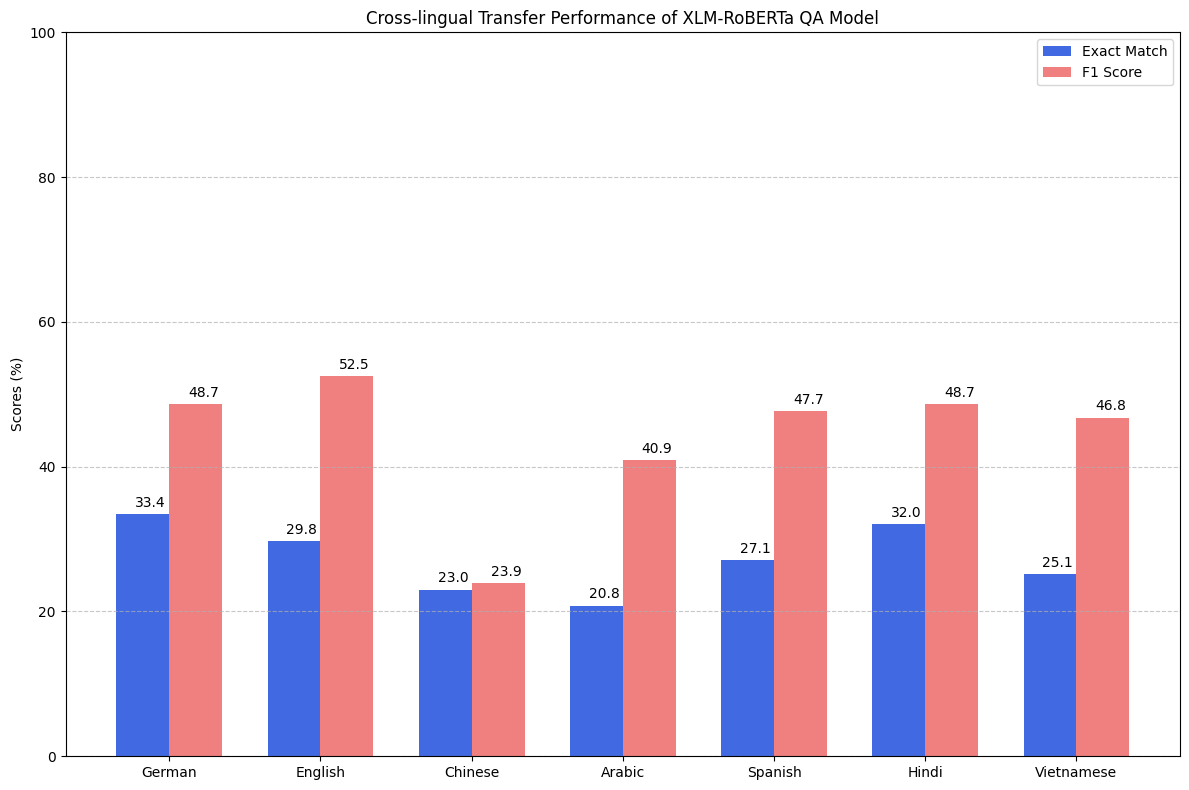


Cross-lingual Transfer Results:
------------------------------------------------------------
Language     | Exact Match (%) | F1 Score (%)   
------------------------------------------------------------
German       | 33.40           | 48.68          
English      | 29.75           | 52.46          
Chinese      | 23.01           | 23.92          
Arabic       | 20.82           | 40.88          
Spanish      | 27.08           | 47.69          
Hindi        | 32.04           | 48.66          
Vietnamese   | 25.12           | 46.78          
------------------------------------------------------------
Average      | 27.32           | 44.15          
------------------------------------------------------------

Performance Gap Analysis (relative to German):
---------------------------------------------------------------------------
Language     | EM Gap (%)   | F1 Gap (%)   | Relative EM (%) | Relative F1 (%)
---------------------------------------------------------------------------
Eng

In [ ]:
# Train on German
if __name__ == "__main__":
    main_multilingual_evaluation(train_language="german")

Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Training model on Spanish data first...
Loading dataset: MLQA with configuration 'mlqa.es.es'

Initializing tokenizer and model...


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Preprocessing datasets...


Map:   0%|          | 0/4602 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

Map:   0%|          | 0/576 [00:00<?, ? examples/s]


Preparing dataloaders...

Training model on Spanish data...


  0%|          | 0/1794 [00:00<?, ?it/s]

	Evaluation for Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/575 [00:00<?, ?it/s]


	Epoch 1: {'exact_match': 25.57, 'f1': 48.36}
New best model saved with F1: 48.36
	Evaluation for Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/575 [00:00<?, ?it/s]


	Epoch 2: {'exact_match': 29.74, 'f1': 53.89}
New best model saved with F1: 53.89
	Evaluation for Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/575 [00:00<?, ?it/s]


	Epoch 3: {'exact_match': 30.26, 'f1': 53.98}
New best model saved with F1: 53.98

Final model saved to ./xlm_r_qa_model_spanish/final_model

Evaluating model on Spanish test set...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]


Evaluation metrics on Spanish test set: {'exact_match': 29.86, 'f1': 52.77}
Loading fine-tuned model from ./xlm_r_qa_model_spanish/best_model


== Evaluation on English ================================================== 

Loading dataset: MLQA with configuration 'mlqa.en.en'


Map:   0%|          | 0/1274 [00:00<?, ? examples/s]


Evaluating model on English test set...


  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


Evaluation metrics on English test set: {'exact_match': 33.36, 'f1': 56.76}


== Evaluation on Chinese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.zh.zh'


Map:   0%|          | 0/565 [00:00<?, ? examples/s]


Evaluating model on Chinese test set...


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]


Evaluation metrics on Chinese test set: {'exact_match': 25.31, 'f1': 26.0}


== Evaluation on Arabic ================================================== 

Loading dataset: MLQA with configuration 'mlqa.ar.ar'


Map:   0%|          | 0/586 [00:00<?, ? examples/s]


Evaluating model on Arabic test set...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]


Evaluation metrics on Arabic test set: {'exact_match': 23.04, 'f1': 42.57}


== Evaluation on German ================================================== 

Loading dataset: MLQA with configuration 'mlqa.de.de'


Map:   0%|          | 0/503 [00:00<?, ? examples/s]


Evaluating model on German test set...


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


Evaluation metrics on German test set: {'exact_match': 33.8, 'f1': 50.77}


== Evaluation on Hindi ================================================== 

Loading dataset: MLQA with configuration 'mlqa.hi.hi'


Map:   0%|          | 0/543 [00:00<?, ? examples/s]


Evaluating model on Hindi test set...


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]


Evaluation metrics on Hindi test set: {'exact_match': 31.12, 'f1': 48.49}


== Evaluation on Vietnamese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.vi.vi'


Map:   0%|          | 0/601 [00:00<?, ? examples/s]


Evaluating model on Vietnamese test set...


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


Evaluation metrics on Vietnamese test set: {'exact_match': 27.79, 'f1': 50.43}




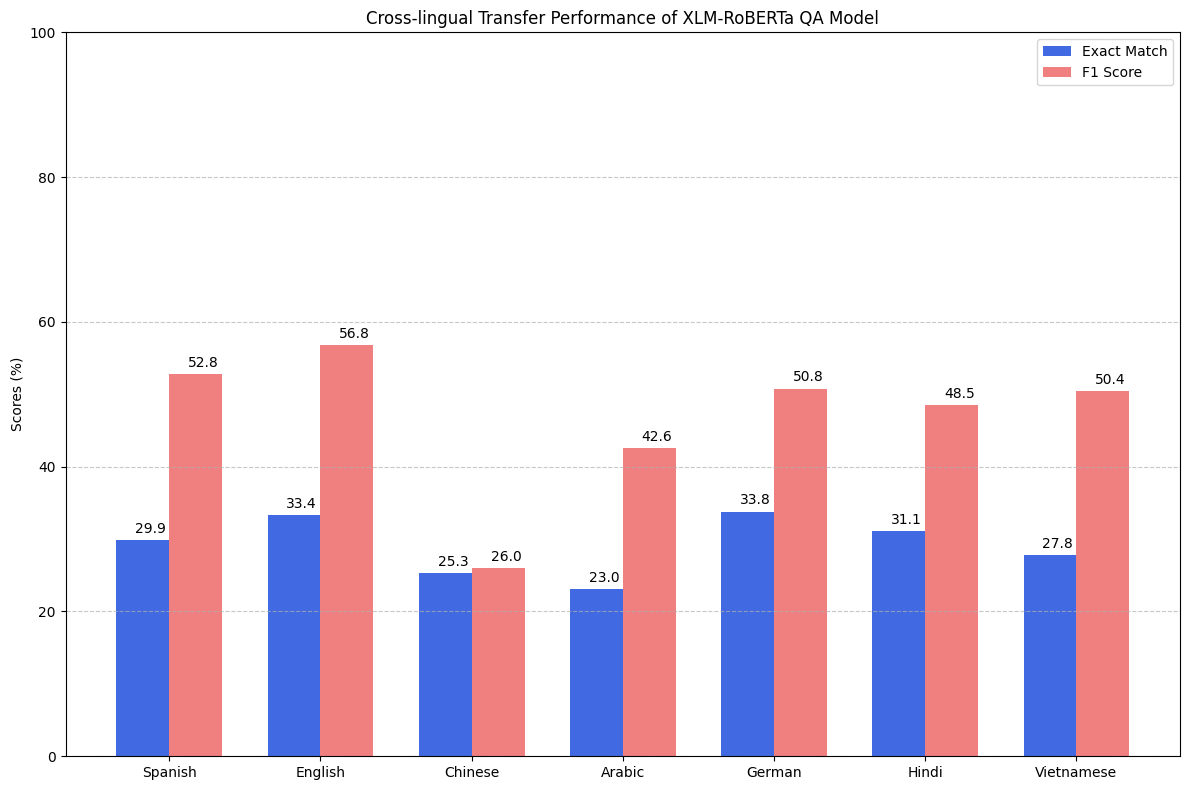


Cross-lingual Transfer Results:
------------------------------------------------------------
Language     | Exact Match (%) | F1 Score (%)   
------------------------------------------------------------
Spanish      | 29.86           | 52.77          
English      | 33.36           | 56.76          
Chinese      | 25.31           | 26.00          
Arabic       | 23.04           | 42.57          
German       | 33.80           | 50.77          
Hindi        | 31.12           | 48.49          
Vietnamese   | 27.79           | 50.43          
------------------------------------------------------------
Average      | 29.18           | 46.83          
------------------------------------------------------------

Performance Gap Analysis (relative to Spanish):
---------------------------------------------------------------------------
Language     | EM Gap (%)   | F1 Gap (%)   | Relative EM (%) | Relative F1 (%)
---------------------------------------------------------------------------
En

In [ ]:
# Train on Spanish
if __name__ == "__main__":
    main_multilingual_evaluation(train_language="spanish")

Loading model from checkpoint: xlm-roberta-base


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training model on Hindi data first...
Loading dataset: MLQA with configuration 'mlqa.hi.hi'

Initializing tokenizer and model...
Loading model from checkpoint: xlm-roberta-base


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Preprocessing datasets...


Map:   0%|          | 0/4340 [00:00<?, ? examples/s]

Map:   0%|          | 0/542 [00:00<?, ? examples/s]

Map:   0%|          | 0/543 [00:00<?, ? examples/s]


Preparing dataloaders...

Training model on Hindi data...


  0%|          | 0/2097 [00:00<?, ?it/s]

	Evaluation for Epoch 1


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/542 [00:00<?, ?it/s]


	Epoch 1: {'exact_match': 32.29, 'f1': 49.24}
New best model saved with F1: 49.24
	Evaluation for Epoch 2


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/542 [00:00<?, ?it/s]


	Epoch 2: {'exact_match': 39.11, 'f1': 56.5}
New best model saved with F1: 56.5
	Evaluation for Epoch 3


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/542 [00:00<?, ?it/s]


	Epoch 3: {'exact_match': 39.85, 'f1': 57.33}
New best model saved with F1: 57.33

Final model saved to ./xlm_r_qa_model_hindi/final_model

Evaluating model on Hindi test set...


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]


Evaluation metrics on Hindi test set: {'exact_match': 37.75, 'f1': 56.04}
Loading fine-tuned model from ./xlm_r_qa_model_hindi/best_model


== Evaluation on English ================================================== 

Loading dataset: MLQA with configuration 'mlqa.en.en'


Map:   0%|          | 0/1274 [00:00<?, ? examples/s]


Evaluating model on English test set...


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


Evaluation metrics on English test set: {'exact_match': 45.76, 'f1': 61.74}


== Evaluation on Chinese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.zh.zh'


Map:   0%|          | 0/565 [00:00<?, ? examples/s]


Evaluating model on Chinese test set...


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]


Evaluation metrics on Chinese test set: {'exact_match': 31.86, 'f1': 32.82}


== Evaluation on Arabic ================================================== 

Loading dataset: MLQA with configuration 'mlqa.ar.ar'


Map:   0%|          | 0/586 [00:00<?, ? examples/s]


Evaluating model on Arabic test set...


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]


Evaluation metrics on Arabic test set: {'exact_match': 26.28, 'f1': 44.08}


== Evaluation on German ================================================== 

Loading dataset: MLQA with configuration 'mlqa.de.de'


Map:   0%|          | 0/503 [00:00<?, ? examples/s]


Evaluating model on German test set...


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


Evaluation metrics on German test set: {'exact_match': 26.84, 'f1': 41.74}


== Evaluation on Spanish ================================================== 

Loading dataset: MLQA with configuration 'mlqa.es.es'


Map:   0%|          | 0/576 [00:00<?, ? examples/s]


Evaluating model on Spanish test set...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]


Evaluation metrics on Spanish test set: {'exact_match': 28.65, 'f1': 47.99}


== Evaluation on Vietnamese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.vi.vi'


Map:   0%|          | 0/601 [00:00<?, ? examples/s]


Evaluating model on Vietnamese test set...


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


Evaluation metrics on Vietnamese test set: {'exact_match': 34.61, 'f1': 53.7}




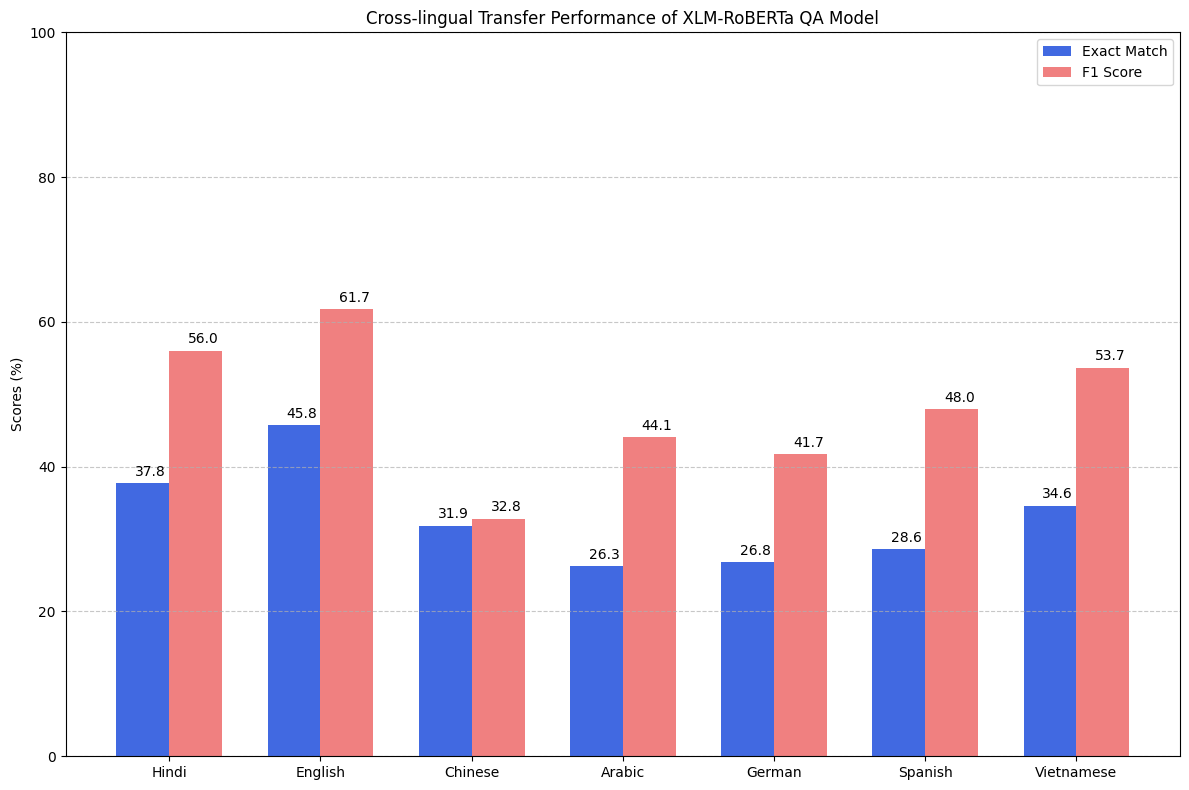


Cross-lingual Transfer Results:
------------------------------------------------------------
Language     | Exact Match (%) | F1 Score (%)   
------------------------------------------------------------
Hindi        | 37.75           | 56.04          
English      | 45.76           | 61.74          
Chinese      | 31.86           | 32.82          
Arabic       | 26.28           | 44.08          
German       | 26.84           | 41.74          
Spanish      | 28.65           | 47.99          
Vietnamese   | 34.61           | 53.70          
------------------------------------------------------------
Average      | 33.11           | 48.30          
------------------------------------------------------------

Performance Gap Analysis (relative to Hindi):
---------------------------------------------------------------------------
Language     | EM Gap (%)   | F1 Gap (%)   | Relative EM (%) | Relative F1 (%)
---------------------------------------------------------------------------
Engl

In [ ]:
# Train on Hindi
if __name__ == "__main__":
    main_multilingual_evaluation(train_language="hindi")

Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Training model on Vietnamese data first...
Loading dataset: MLQA with configuration 'mlqa.vi.vi'


Generating test split:   0%|          | 0/5495 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/511 [00:00<?, ? examples/s]


Initializing tokenizer and model...
Loading model from checkpoint: xlm-roberta-base


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Preprocessing datasets...


Map:   0%|          | 0/4804 [00:00<?, ? examples/s]

Map:   0%|          | 0/601 [00:00<?, ? examples/s]

Map:   0%|          | 0/601 [00:00<?, ? examples/s]


Preparing dataloaders...

Training model on Vietnamese data...


  0%|          | 0/2403 [00:00<?, ?it/s]

	Evaluation for Epoch 1


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


	Epoch 1: {'exact_match': 31.78, 'f1': 53.77}
New best model saved with F1: 53.77
	Evaluation for Epoch 2


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


	Epoch 2: {'exact_match': 39.1, 'f1': 58.62}
New best model saved with F1: 58.62
	Evaluation for Epoch 3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


	Epoch 3: {'exact_match': 37.94, 'f1': 58.61}

Final model saved to ./xlm_r_qa_model_vietnamese/final_model

Evaluating model on Vietnamese test set...


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


Evaluation metrics on Vietnamese test set: {'exact_match': 34.94, 'f1': 56.45}
Loading fine-tuned model from ./xlm_r_qa_model_vietnamese/best_model


== Evaluation on English ================================================== 

Loading dataset: MLQA with configuration 'mlqa.en.en'


Map:   0%|          | 0/1274 [00:00<?, ? examples/s]


Evaluating model on English test set...


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


Evaluation metrics on English test set: {'exact_match': 47.49, 'f1': 65.19}


== Evaluation on Chinese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.zh.zh'


Generating test split:   0%|          | 0/5137 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/504 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]


Evaluating model on Chinese test set...


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]


Evaluation metrics on Chinese test set: {'exact_match': 29.91, 'f1': 30.64}


== Evaluation on Arabic ================================================== 

Loading dataset: MLQA with configuration 'mlqa.ar.ar'


Generating test split:   0%|          | 0/5335 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/586 [00:00<?, ? examples/s]


Evaluating model on Arabic test set...


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]


Evaluation metrics on Arabic test set: {'exact_match': 27.99, 'f1': 45.76}


== Evaluation on German ================================================== 

Loading dataset: MLQA with configuration 'mlqa.de.de'


Generating test split:   0%|          | 0/4517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/512 [00:00<?, ? examples/s]

Map:   0%|          | 0/503 [00:00<?, ? examples/s]


Evaluating model on German test set...


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


Evaluation metrics on German test set: {'exact_match': 31.21, 'f1': 48.28}


== Evaluation on Spanish ================================================== 

Loading dataset: MLQA with configuration 'mlqa.es.es'


Generating test split:   0%|          | 0/5253 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/576 [00:00<?, ? examples/s]


Evaluating model on Spanish test set...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]


Evaluation metrics on Spanish test set: {'exact_match': 24.13, 'f1': 46.37}


== Evaluation on Hindi ================================================== 

Loading dataset: MLQA with configuration 'mlqa.hi.hi'


Generating test split:   0%|          | 0/4918 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/507 [00:00<?, ? examples/s]

Map:   0%|          | 0/543 [00:00<?, ? examples/s]


Evaluating model on Hindi test set...


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]


Evaluation metrics on Hindi test set: {'exact_match': 28.91, 'f1': 46.28}




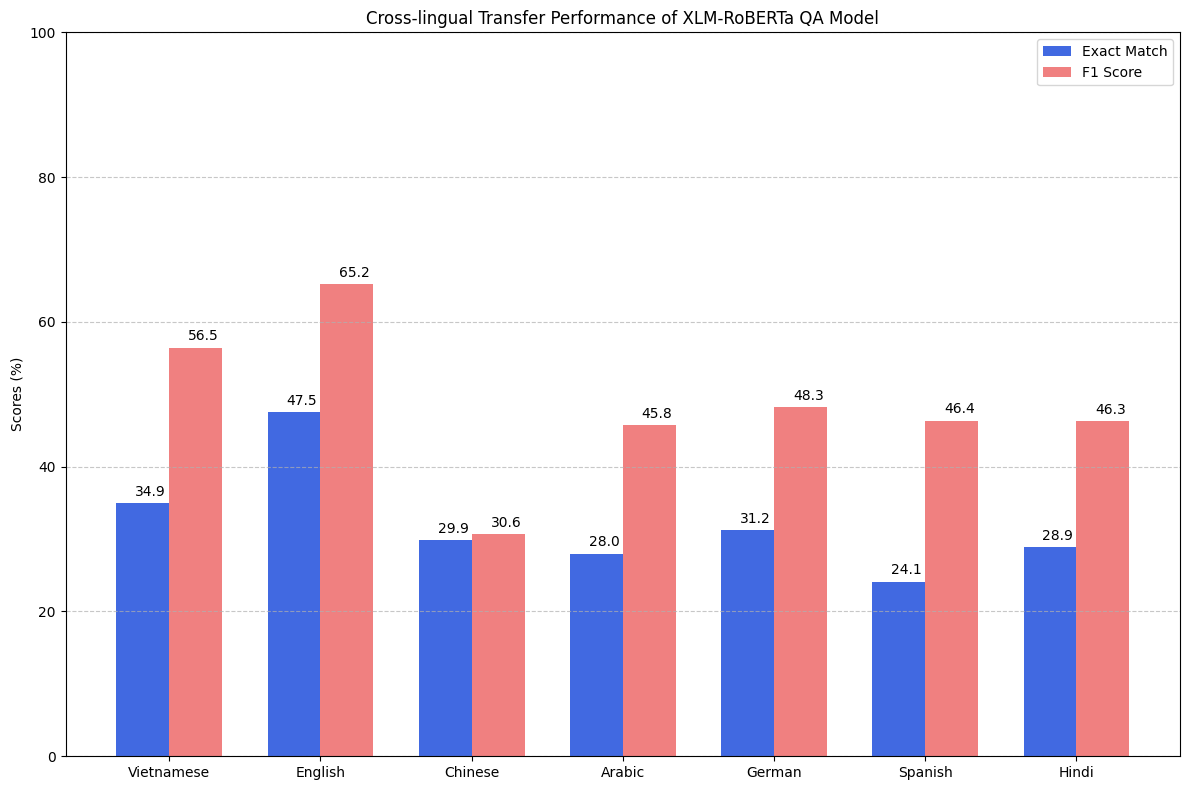


Cross-lingual Transfer Results:
------------------------------------------------------------
Language     | Exact Match (%) | F1 Score (%)   
------------------------------------------------------------
Vietnamese   | 34.94           | 56.45          
English      | 47.49           | 65.19          
Chinese      | 29.91           | 30.64          
Arabic       | 27.99           | 45.76          
German       | 31.21           | 48.28          
Spanish      | 24.13           | 46.37          
Hindi        | 28.91           | 46.28          
------------------------------------------------------------
Average      | 32.08           | 48.42          
------------------------------------------------------------

Performance Gap Analysis (relative to Vietnamese):
---------------------------------------------------------------------------
Language     | EM Gap (%)   | F1 Gap (%)   | Relative EM (%) | Relative F1 (%)
---------------------------------------------------------------------------

In [ ]:
# Train on Vietnamese
if __name__ == "__main__":
    main_multilingual_evaluation(train_language="vietnamese")

Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Training model on Chinese data first...
Loading dataset: MLQA with configuration 'mlqa.zh.zh'

Initializing tokenizer and model...


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from checkpoint: xlm-roberta-base

Preprocessing datasets...


Map:   0%|          | 0/4512 [00:00<?, ? examples/s]

Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]


Preparing dataloaders...

Training model on Chinese data...


  0%|          | 0/1884 [00:00<?, ?it/s]

	Evaluation for Epoch 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]


	Epoch 1: {'exact_match': 34.22, 'f1': 34.85}
New best model saved with F1: 34.85
	Evaluation for Epoch 2


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]


	Epoch 2: {'exact_match': 39.36, 'f1': 39.86}
New best model saved with F1: 39.86
	Evaluation for Epoch 3


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/564 [00:00<?, ?it/s]


	Epoch 3: {'exact_match': 38.83, 'f1': 39.48}

Final model saved to ./xlm_r_qa_model_chinese/final_model

Evaluating model on Chinese test set...


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]


Evaluation metrics on Chinese test set: {'exact_match': 39.12, 'f1': 39.9}
Loading fine-tuned model from ./xlm_r_qa_model_chinese/best_model


== Evaluation on English ================================================== 

Loading dataset: MLQA with configuration 'mlqa.en.en'


Map:   0%|          | 0/1274 [00:00<?, ? examples/s]


Evaluating model on English test set...


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]


Evaluation metrics on English test set: {'exact_match': 45.29, 'f1': 62.85}


== Evaluation on Arabic ================================================== 

Loading dataset: MLQA with configuration 'mlqa.ar.ar'


Map:   0%|          | 0/586 [00:00<?, ? examples/s]


Evaluating model on Arabic test set...


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]


Evaluation metrics on Arabic test set: {'exact_match': 22.87, 'f1': 40.88}


== Evaluation on German ================================================== 

Loading dataset: MLQA with configuration 'mlqa.de.de'


Map:   0%|          | 0/503 [00:00<?, ? examples/s]


Evaluating model on German test set...


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]


Evaluation metrics on German test set: {'exact_match': 27.83, 'f1': 46.84}


== Evaluation on Spanish ================================================== 

Loading dataset: MLQA with configuration 'mlqa.es.es'


Map:   0%|          | 0/576 [00:00<?, ? examples/s]


Evaluating model on Spanish test set...


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]


Evaluation metrics on Spanish test set: {'exact_match': 25.69, 'f1': 45.22}


== Evaluation on Hindi ================================================== 

Loading dataset: MLQA with configuration 'mlqa.hi.hi'


Map:   0%|          | 0/543 [00:00<?, ? examples/s]


Evaluating model on Hindi test set...


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]


Evaluation metrics on Hindi test set: {'exact_match': 34.99, 'f1': 51.47}


== Evaluation on Vietnamese ================================================== 

Loading dataset: MLQA with configuration 'mlqa.vi.vi'


Map:   0%|          | 0/601 [00:00<?, ? examples/s]


Evaluating model on Vietnamese test set...


  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]


Evaluation metrics on Vietnamese test set: {'exact_match': 33.94, 'f1': 53.38}




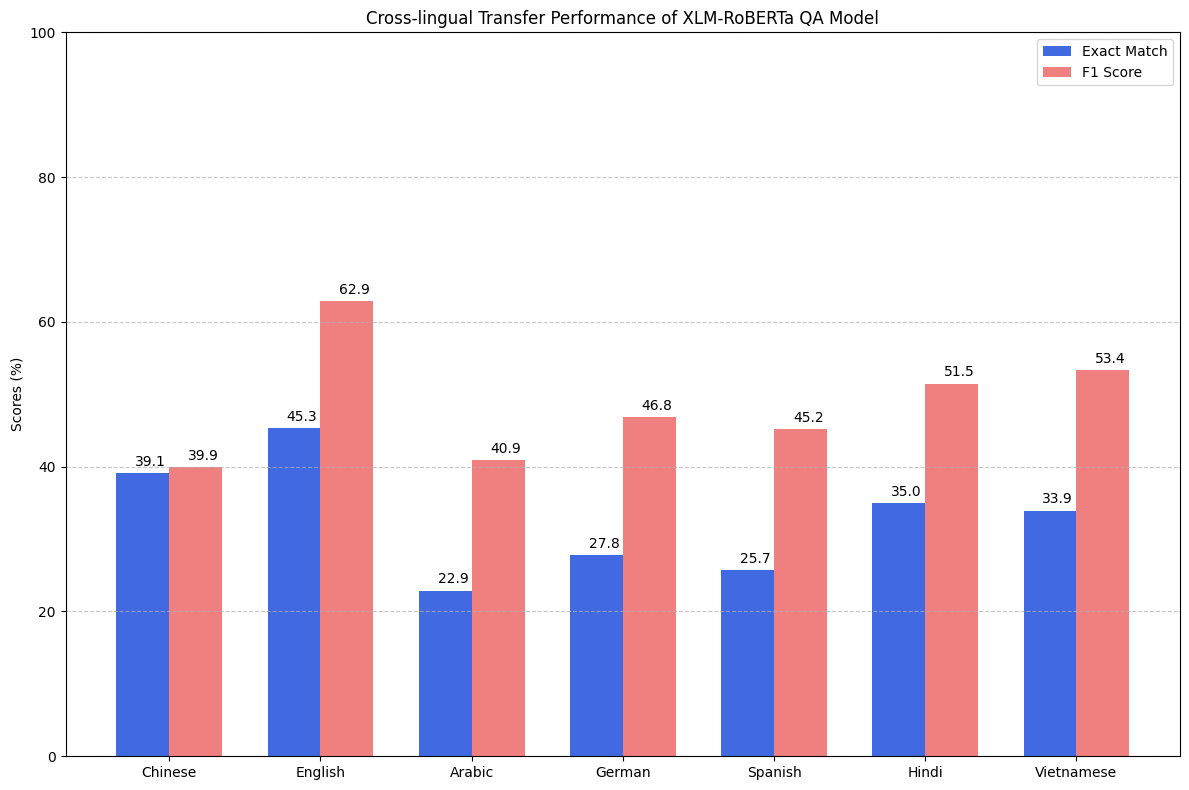


Cross-lingual Transfer Results:
------------------------------------------------------------
Language     | Exact Match (%) | F1 Score (%)   
------------------------------------------------------------
Chinese      | 39.12           | 39.90          
English      | 45.29           | 62.85          
Arabic       | 22.87           | 40.88          
German       | 27.83           | 46.84          
Spanish      | 25.69           | 45.22          
Hindi        | 34.99           | 51.47          
Vietnamese   | 33.94           | 53.38          
------------------------------------------------------------
Average      | 32.82           | 48.65          
------------------------------------------------------------

Performance Gap Analysis (relative to Chinese):
---------------------------------------------------------------------------
Language     | EM Gap (%)   | F1 Gap (%)   | Relative EM (%) | Relative F1 (%)
---------------------------------------------------------------------------
En

In [ ]:
# Train on Simplified Chinese
if __name__ == "__main__":
    main_multilingual_evaluation(train_language="chinese")

# Visualisations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

In [ ]:
# Define the data
data = {
    "Language": ["English", "Chinese", "Arabic", "German", "Spanish", "Hindi", "Vietnamese", "Average"],
    "Exact Match (%)": [57.30, 38.41, 30.72, 37.97, 32.12, 40.70, 43.59, 40.12],
    "F1 Score (%)": [75.24, 39.14, 52.33, 54.58, 57.43, 57.59, 64.93, 57.32]
}

# Create the DataFrame
results_eng = pd.DataFrame(data)

# Display the DataFrame
results_eng

Language  Exact Match (%)  F1 Score (%)
0     English            57.30         75.24
1     Chinese            38.41         39.14
2      Arabic            30.72         52.33
3      German            37.97         54.58
4     Spanish            32.12         57.43
5       Hindi            40.70         57.59
6  Vietnamese            43.59         64.93
7     Average            40.12         57.32

In [ ]:
# Define the data
data_arabic = {
    "Language": ["Arabic", "English", "Chinese", "German", "Spanish", "Hindi", "Vietnamese", "Average"],
    "Exact Match (%)": [28.84, 44.27, 30.97, 29.22, 25.17, 31.68, 29.28, 31.35],
    "F1 Score (%)": [48.57, 60.70, 31.83, 46.36, 46.62, 48.01, 50.76, 47.55]
}

# Create the DataFrame
results_arabic = pd.DataFrame(data_arabic)

# Display the DataFrame
results_arabic

Language  Exact Match (%)  F1 Score (%)
0      Arabic            28.84         48.57
1     English            44.27         60.70
2     Chinese            30.97         31.83
3      German            29.22         46.36
4     Spanish            25.17         46.62
5       Hindi            31.68         48.01
6  Vietnamese            29.28         50.76
7     Average            31.35         47.55

In [ ]:
# Define the data
data_german = {
    "Language": ["German", "English", "Chinese", "Arabic", "Spanish", "Hindi", "Vietnamese", "Average"],
    "Exact Match (%)": [33.40, 29.75, 23.01, 20.82, 27.08, 32.04, 25.12, 27.32],
    "F1 Score (%)": [48.68, 52.46, 23.92, 40.88, 47.69, 48.66, 46.78, 44.15]
}

# Create the DataFrame
results_german = pd.DataFrame(data_german)

# Display the DataFrame
results_german

Language  Exact Match (%)  F1 Score (%)
0      German            33.40         48.68
1     English            29.75         52.46
2     Chinese            23.01         23.92
3      Arabic            20.82         40.88
4     Spanish            27.08         47.69
5       Hindi            32.04         48.66
6  Vietnamese            25.12         46.78
7     Average            27.32         44.15

In [ ]:
# Define the data
data_spanish = {
    "Language": ["Spanish", "English", "Chinese", "Arabic", "German", "Hindi", "Vietnamese", "Average"],
    "Exact Match (%)": [29.86, 33.36, 25.31, 23.04, 33.80, 31.12, 27.79, 29.18],
    "F1 Score (%)": [52.77, 56.76, 26.00, 42.57, 50.77, 48.49, 50.43, 46.83]
}

# Create the DataFrame
results_spanish = pd.DataFrame(data_spanish)

# Display the DataFrame
results_spanish

Language  Exact Match (%)  F1 Score (%)
0     Spanish            29.86         52.77
1     English            33.36         56.76
2     Chinese            25.31         26.00
3      Arabic            23.04         42.57
4      German            33.80         50.77
5       Hindi            31.12         48.49
6  Vietnamese            27.79         50.43
7     Average            29.18         46.83

In [ ]:
# Define the data
data_hindi = {
    "Language": ["Hindi", "English", "Chinese", "Arabic", "German", "Spanish", "Vietnamese", "Average"],
    "Exact Match (%)": [37.75, 45.76, 31.86, 26.28, 26.84, 28.65, 34.61, 33.11],
    "F1 Score (%)": [56.04, 61.74, 32.82, 44.08, 41.74, 47.99, 53.70, 48.30]
}

# Create the DataFrame
results_hindi = pd.DataFrame(data_hindi)

# Display the DataFrame
results_hindi

Language  Exact Match (%)  F1 Score (%)
0       Hindi            37.75         56.04
1     English            45.76         61.74
2     Chinese            31.86         32.82
3      Arabic            26.28         44.08
4      German            26.84         41.74
5     Spanish            28.65         47.99
6  Vietnamese            34.61         53.70
7     Average            33.11         48.30

In [ ]:
# Define the data
data_vietnamese = {
    "Language": ["Vietnamese", "English", "Chinese", "Arabic", "German", "Spanish", "Hindi", "Average"],
    "Exact Match (%)": [34.94, 47.49, 29.91, 27.99, 31.21, 24.13, 28.91, 32.08],
    "F1 Score (%)": [56.45, 65.19, 30.64, 45.76, 48.28, 46.37, 46.28, 48.42]
}

# Create the DataFrame
results_vietnamese = pd.DataFrame(data_vietnamese)

# Display the DataFrame
results_vietnamese

Language  Exact Match (%)  F1 Score (%)
0  Vietnamese            34.94         56.45
1     English            47.49         65.19
2     Chinese            29.91         30.64
3      Arabic            27.99         45.76
4      German            31.21         48.28
5     Spanish            24.13         46.37
6       Hindi            28.91         46.28
7     Average            32.08         48.42

In [ ]:
# Define the data
data_chinese = {
    "Language": ["Chinese", "English", "Arabic", "German", "Spanish", "Hindi", "Vietnamese", "Average"],
    "Exact Match (%)": [39.12, 45.29, 22.87, 27.83, 25.69, 34.99, 33.94, 32.82],
    "F1 Score (%)": [39.90, 62.85, 40.88, 46.84, 45.22, 51.47, 53.38, 48.65]
}

# Create the DataFrame
results_chinese = pd.DataFrame(data_chinese)

# Display the DataFrame
results_chinese

Language  Exact Match (%)  F1 Score (%)
0     Chinese            39.12         39.90
1     English            45.29         62.85
2      Arabic            22.87         40.88
3      German            27.83         46.84
4     Spanish            25.69         45.22
5       Hindi            34.99         51.47
6  Vietnamese            33.94         53.38
7     Average            32.82         48.65

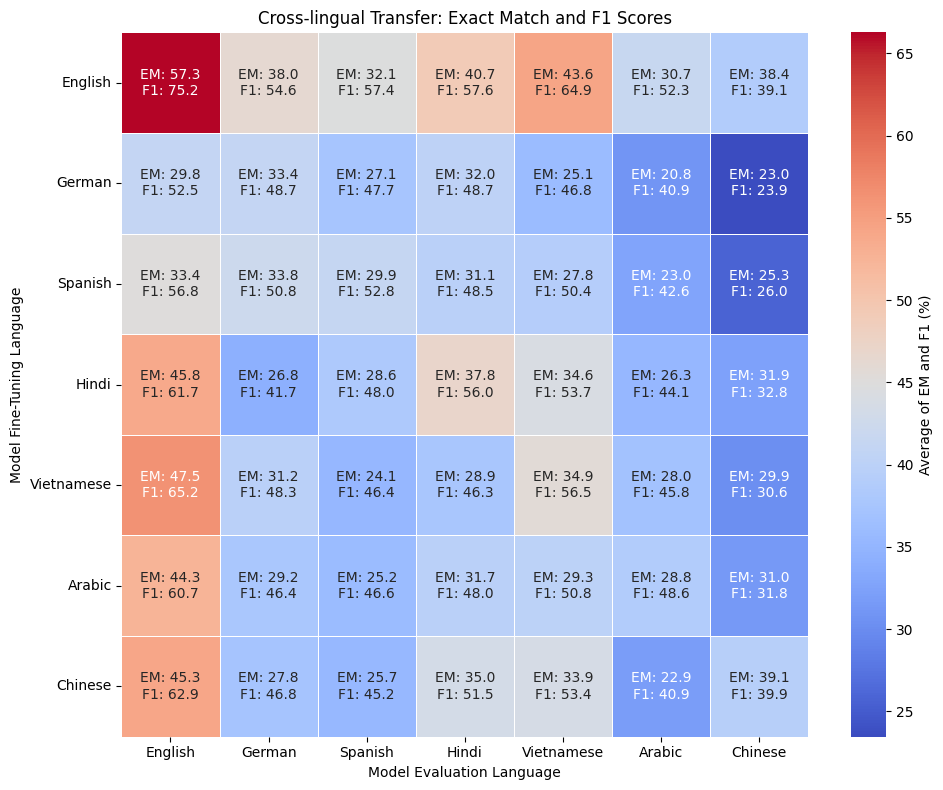

In [ ]:
# Create a dictionary to hold the DataFrames for each model
dfs = {
    'english': results_eng,
    'german': results_german,
    'spanish': results_spanish,
    'hindi': results_hindi,
    'vietnamese': results_vietnamese,
    'arabic': results_arabic,
    'chinese': results_chinese
}

# List of languages
languages = ["English", "German", "Spanish", "Hindi", "Vietnamese", "Arabic", "Chinese"]

# Create a matrix to store the average EM and F1 scores
heatmap_data = pd.DataFrame(index=languages, columns=languages)
annotations = pd.DataFrame(index=languages, columns=languages)

# Populate the matrix with the average of EM and F1 for each language pair and prepare annotations
for train_lang in languages:
    for pred_lang in languages:
        train_data = dfs[train_lang.lower()]
        pred_data = train_data[train_data["Language"] == pred_lang]

        if not pred_data.empty:
            em_score = pred_data["Exact Match (%)"].values[0]
            f1_score = pred_data["F1 Score (%)"].values[0]
            em_f1_avg = (em_score + f1_score) / 2
            heatmap_data.loc[train_lang, pred_lang] = em_f1_avg
            annotations.loc[train_lang, pred_lang] = f"EM: {em_score:.1f}\nF1: {f1_score:.1f}"
        else:
            heatmap_data.loc[train_lang, pred_lang] = 0
            annotations.loc[train_lang, pred_lang] = "EM: 0.0\nF1: 0.0"

# Convert the values to numeric
heatmap_data = heatmap_data.apply(pd.to_numeric)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=annotations,
    cmap="coolwarm",
    fmt="",
    linewidths=.5,
    cbar_kws={'label': 'Average of EM and F1 (%)'},
    yticklabels=heatmap_data.index
)

# Set y-axis tick label rotation
plt.yticks(rotation=0)

plt.title("Cross-lingual Transfer: Exact Match and F1 Scores")
plt.ylabel("Model Fine-Tuning Language")
plt.xlabel("Model Evaluation Language")
plt.tight_layout()
plt.show()

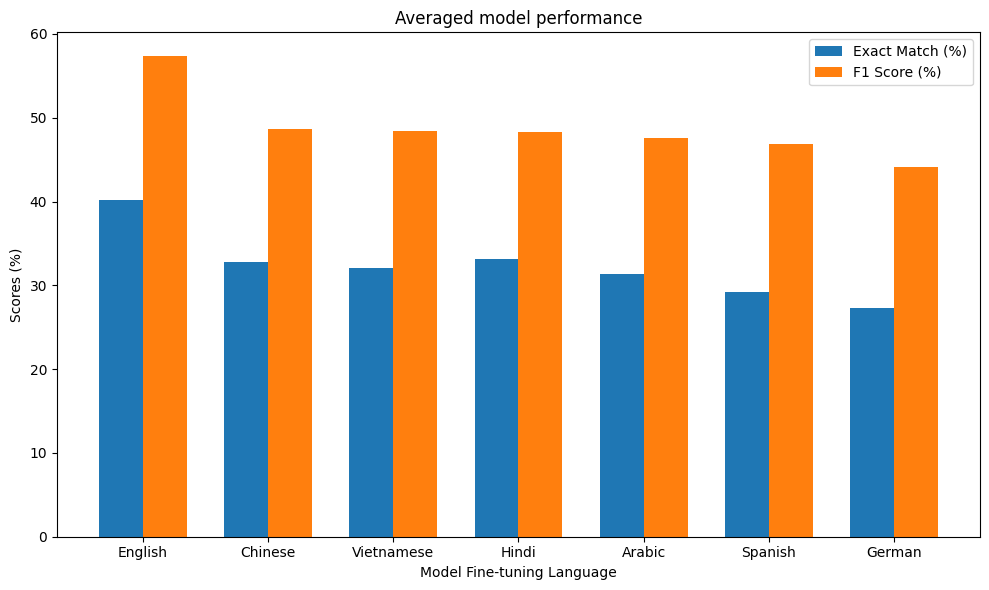

In [ ]:
# Data
languages = ['English', 'Arabic', 'German', 'Spanish', 'Hindi', 'Vietnamese', 'Chinese']
exact_match = [40.12, 31.35, 27.32, 29.18, 33.11, 32.08, 32.82]
f1_score = [57.32, 47.55, 44.15, 46.83, 48.30, 48.42, 48.65]

# Sort by F1 score in descending order
sorted_indices = np.argsort(f1_score)[::-1]
languages_sorted = np.array(languages)[sorted_indices]
exact_match_sorted = np.array(exact_match)[sorted_indices]
f1_score_sorted = np.array(f1_score)[sorted_indices]

# Plotting
x = np.arange(len(languages_sorted))

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35

bar1 = ax.bar(x - width/2, exact_match_sorted, width, label='Exact Match (%)')
bar2 = ax.bar(x + width/2, f1_score_sorted, width, label='F1 Score (%)')

ax.set_xlabel('Model Fine-tuning Language')
ax.set_ylabel('Scores (%)')
ax.set_title('Averaged model performance')
ax.set_xticks(x)
ax.set_xticklabels(languages_sorted)
ax.legend()

plt.tight_layout()
plt.show()

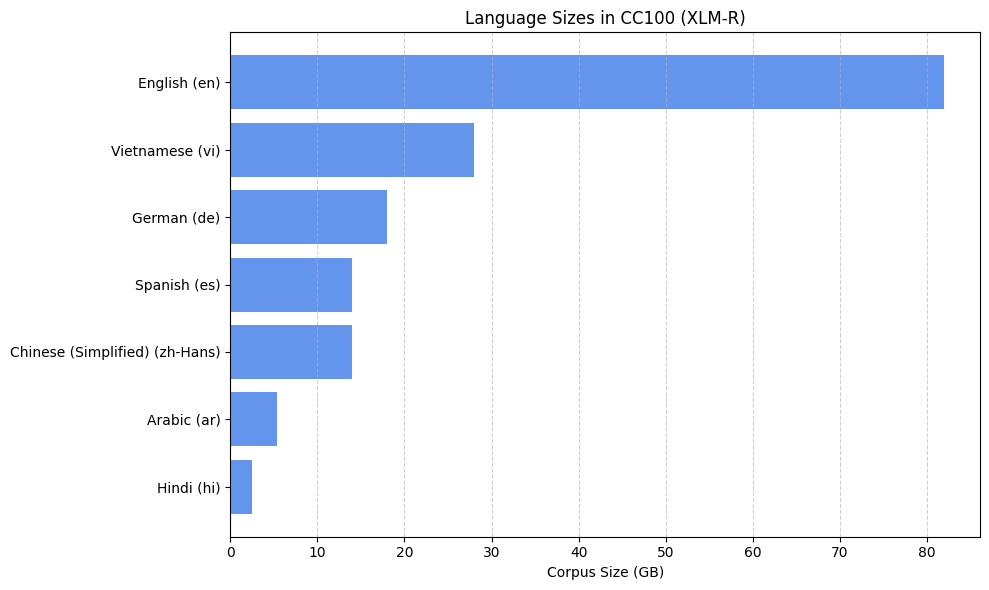

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Selected languages and their sizes from CC100
selected_data = {
    'English (en)': '82G',
    'Spanish (es)': '14G',
    'German (de)': '18G',
    'Hindi (hi)': '2.5G',
    'Arabic (ar)': '5.4G',
    'Chinese (Simplified) (zh-Hans)': '14G',
    'Vietnamese (vi)': '28G'
}

# Convert sizes to GB
def convert_to_gb(size_str):
    if size_str.endswith('G'):
        return float(size_str[:-1])
    elif size_str.endswith('M'):
        return float(size_str[:-1]) / 1024
    else:
        return 0.0

# Create DataFrame
df = pd.DataFrame(selected_data.items(), columns=['Language', 'Size'])
df['Size_GB'] = df['Size'].apply(convert_to_gb)

# Sort for cleaner plotting
df = df.sort_values(by='Size_GB', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df['Language'], df['Size_GB'], color='cornflowerblue')
plt.xlabel('Corpus Size (GB)')
plt.title('Language Sizes in CC100 (XLM-R)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-12-5c7beb1df327>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = df.replace(mapping)


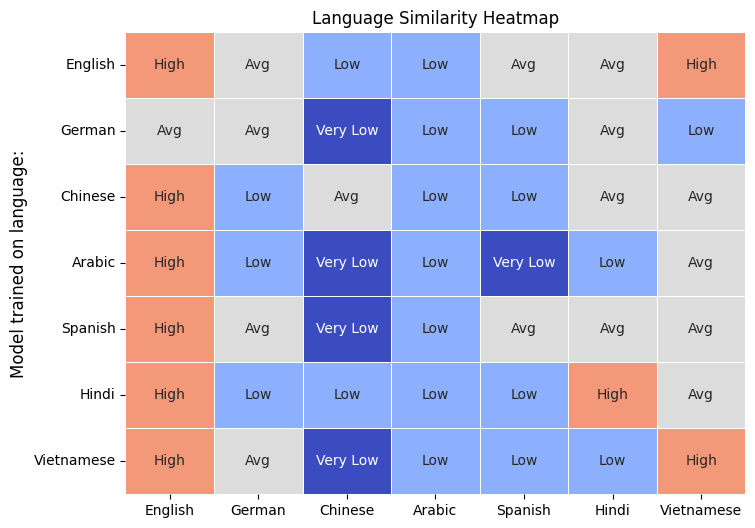

In [ ]:
# Example data (replace with actual values)
data = [
    ['High', 'Avg', 'Low', 'Low', 'Avg', 'Avg', 'High'],
    ['Avg', 'Avg', 'Very Low', 'Low', 'Low', 'Avg', 'Low'],
    ['High', 'Low', 'Avg', 'Low', 'Low', 'Avg', 'Avg'],
    ['High', 'Low', 'Very Low', 'Low', 'Very Low', 'Low', 'Avg'],
    ['High', 'Avg', 'Very Low', 'Low', 'Avg', 'Avg', 'Avg'],
    ['High', 'Low', 'Low', 'Low', 'Low', 'High', 'Avg'],
    ['High', 'Avg', 'Very Low', 'Low', 'Low', 'Low', 'High'],
]

languages = ["English", "German", "Chinese", "Arabic", "Spanish", "Hindi", "Vietnamese"]
df = pd.DataFrame(data, index=languages, columns=languages)

# Convert categorical values to numerical scores for visualization
mapping = {"Very Low": 1, "Low": 2, "Avg": 3, "High": 4, "Very High": 5}
df_numeric = df.replace(mapping)

# Define the bounds and the corresponding colors for each value
vmin = 1
vmax = 5
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=3, vmax=vmax)

plt.figure(figsize=(8, 6))

# Create heatmap with no colorbar and custom y-axis label
sns.heatmap(df_numeric, annot=df.values, cmap="coolwarm", fmt='', linewidths=0.5, cbar=False, norm=norm)

# Set custom y-axis label
plt.ylabel('Model trained on language:', fontsize=12, rotation=90)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0, fontsize=10)  # Adjust fontsize as needed

# Title for the plot
plt.title("Language Similarity Heatmap")

# Show plot
plt.show()

<ipython-input-13-215c16744e82>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = df.replace(mapping)


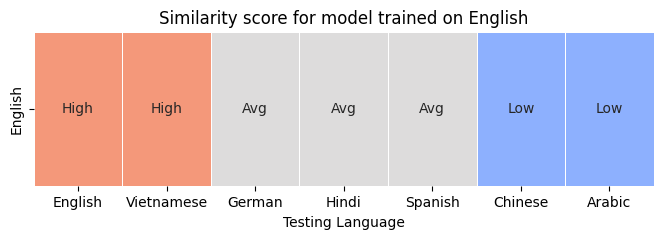

In [ ]:
# Example data (replace with actual values)
data = ['High', 'Avg', 'Low', 'Low', 'Avg', 'Avg', 'High']

languages = ["English"]
df = pd.DataFrame([data], index=languages, columns=["English", "German", "Chinese", "Arabic", "Spanish", "Hindi", "Vietnamese"])

# Convert categorical values to numerical scores for visualization
mapping = {"Very Low": 1, "Low": 2, "Avg": 3, "High": 4, "Very High": 5}
df_numeric = df.replace(mapping)

# Sort columns in descending order based on values in the "English" row
df_numeric_sorted = df_numeric.sort_values(by="English", axis=1, ascending=False)

# Reorder the original categorical data similarly
df_sorted = df[["English", "German", "Chinese", "Arabic", "Spanish", "Hindi", "Vietnamese"]].reindex(columns=df_numeric_sorted.columns)

# Define the bounds and the corresponding colors for each value
vmin = 1
vmax = 5
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=3, vmax=vmax)

# Plot for English model (only one row of data)
plt.figure(figsize=(8, 2))  # Adjust the height to make it look more compact
sns.heatmap(df_numeric_sorted, annot=df_sorted.values, cmap="coolwarm", fmt='', linewidths=0.5, cbar=False, norm=norm, cbar_kws={"shrink": 0.6})

plt.title("Similarity score for model trained on English")
plt.xlabel('Testing Language', fontsize=10)
plt.xticks(rotation=0, fontsize=10)
plt.show()

# Language Similarity Metric

In [ ]:
! pip install lang2vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 2.9 MB/s eta 0:00:00


In [ ]:
import lang2vec.lang2vec as l2v
from scipy.spatial.distance import cosine
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Define the languages to calculate distances for
languages = ["ara", "eng", "deu", "hin", "spa", "vie", "zho"]

# Feature sets to consider
feature_sets = [
    "fam",             # Genetic
    "geo",             # Geographical
    "phonology_wals",  # Phonological
    "syntax_wals",     # Syntactic
    "syntax_ethnologue", # Featural
    "inventory_ethnologue" # Inventory
]

# Function to convert feature list to a numeric array, handling missing values
def to_numeric(features):
    if '--' in features:  # If there are missing values
        return np.array([1.0] * len(features))  # Assign a large distance for missing data
    return np.array([float(x) if x != '--' else 0.0 for x in features])  # Convert to numeric

distances = {}

# Iterate over each pair of languages
for i, lang1 in enumerate(languages):
    for j, lang2 in enumerate(languages):
        if i < j:
            total_distance = 0
            # For each feature set, calculate the cosine distance
            for feature_set in feature_sets:
                features1 = l2v.get_features(lang1, feature_set).get(lang1, [])
                features2 = l2v.get_features(lang2, feature_set).get(lang2, [])

                # Convert feature lists to numeric arrays
                features1_numeric = to_numeric(features1)
                features2_numeric = to_numeric(features2)

                total_distance += cosine(features1_numeric, features2_numeric)

            # Calculate average distance for this language pair
            avg_distance = total_distance / len(feature_sets)
            distances[(lang1, lang2)] = avg_distance

# Sort the distances dictionary by the distance values
sorted_distances = sorted(distances.items(), key=lambda x: x[1])

# Print the sorted average distances
for pair, distance in sorted_distances:
    print(f"Average distance between {pair[0]} and {pair[1]}: {distance.round(4)}")

Average distance between eng and deu: 0.0763
Average distance between deu and spa: 0.1477
Average distance between eng and spa: 0.1513
Average distance between deu and hin: 0.1525
Average distance between eng and hin: 0.1605
Average distance between hin and spa: 0.1642
Average distance between vie and zho: 0.1679
Average distance between ara and deu: 0.1695
Average distance between ara and spa: 0.1699
Average distance between hin and vie: 0.17
Average distance between hin and zho: 0.1704
Average distance between ara and eng: 0.1716
Average distance between ara and hin: 0.1745
Average distance between deu and zho: 0.1839
Average distance between ara and zho: 0.1843
Average distance between ara and vie: 0.1855
Average distance between eng and zho: 0.186
Average distance between deu and vie: 0.1883
Average distance between spa and zho: 0.1895
Average distance between eng and vie: 0.1912
Average distance between spa and vie: 0.1937


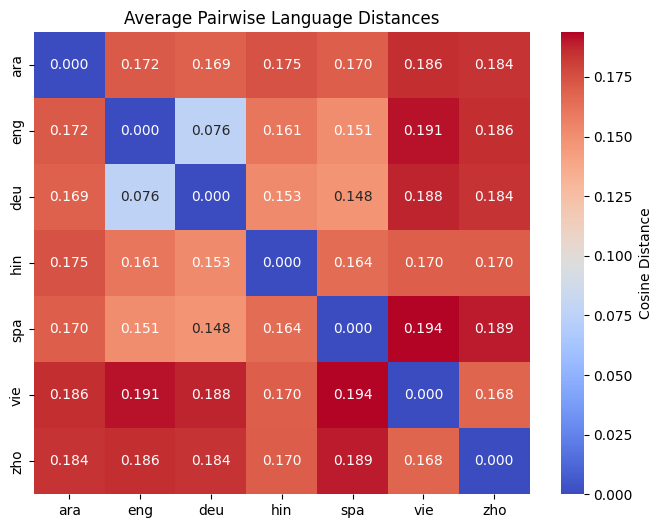

In [ ]:
# Convert the dictionary of distances into a matrix for a heatmap
distance_matrix = np.zeros((len(languages), len(languages)))

# Populate the matrix with the calculated distances
for i, lang1 in enumerate(languages):
    for j, lang2 in enumerate(languages):
        if i < j:
            distance_matrix[i, j] = distances[(lang1, lang2)]
            distance_matrix[j, i] = distances[(lang1, lang2)]  # Symmetric matrix

# Create a dataframe
distance_df = pd.DataFrame(distance_matrix, index=languages, columns=languages)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True,  cmap="coolwarm", fmt=".3f", cbar_kws={'label': 'Cosine Distance'})
plt.title("Average Pairwise Language Distances")
plt.show()
